In [1]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Load preprocessed data stored in NumPy arrays
data = np.load('data.npy')
labels = np.load('labels.npy')

# Declare hyperparameter constants
    # Initial learning rate
    # Epoch number
    # Batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
# Apply one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Split data to two partitions: training set (80%) and testing set (20%)
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# Prepare image generator for training data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [4]:
imageSize=224

# Load the MobileNetV2 network with pre-trained weights (imagenet)
# and excluding head network layer
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(imageSize, imageSize, 3)))

# Build a new head network layer
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Prepend new head Fully Connected model to the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# Loop over layers of base model and make sure they will not be
# trained or updated during the backpropagation process
for layer in baseModel.layers:
    layer.trainable = False
    
# Compile the model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# Train the head layer of the model
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# Make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)

# For each image in the testing set, find the index of 
# the label with corresponding highest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Display classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

# Serialize the model to file
model.save('mask_detector.model', save_format="h5")

C:\Users\lunesa\anaconda3\envs\env-a\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


  ...
    to  
  ['...']
Train for 34 steps, validate on 276 samples
Epoch 1/20
34/34 [==============================] - 248s 7s/step - loss: 0.7129 - accuracy: 0.6320 - val_loss: 0.3795 - val_accuracy: 0.8594
Epoch 2/20
34/34 [==============================] - 248s 7s/step - loss: 0.4507 - accuracy: 0.7846 - val_loss: 0.2225 - val_accuracy: 0.9414
Epoch 3/20
34/34 [==============================] - 249s 7s/step - loss: 0.3243 - accuracy: 0.8642 - val_loss: 0.1616 - val_accuracy: 0.9609
Epoch 4/20
34/34 [==============================] - 287s 8s/step - loss: 0.2686 - accuracy: 0.8933 - val_loss: 0.1312 - val_accuracy: 0.9648
Epoch 5/20
34/34 [==============================] - 229s 7s/step - loss: 0.2196 - accuracy: 0.9157 - val_loss: 0.1025 - val_accuracy: 0.9648
Epoch 6/20
34/34 [==============================] - 218s 6s/step - loss: 0.2241 - accuracy: 0.9139 - val_loss: 0.0865 - val_accuracy: 0.9688
Epoch 7/20
34/34 [==============================] - 222s 7s/step - loss: 0.1798 - acc

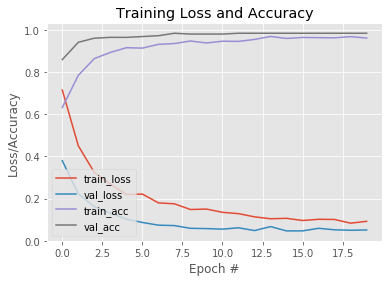

In [5]:
# Plot training and testing accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot.png')